In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [121]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_231/func_0/'

In [122]:
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220824_142240.h5')
f = h5py.File(closed_loop_h5_file, 'r')

In [123]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 2000

behavior_traces = {}
mean_trace = {}
sem_trace = {}
#for angle in [0,180]:
for behavior in ['Z', 'h', 'Y']:
    behavior_traces_,mean_trace,sem_trace = extract_traces(fictrac,
                                                          stimulus_start_times,
                                                          pre_window,
                                                          post_window,
                                                          behavior)
    behavior_traces[behavior] = behavior_traces_

loading photodiode data... done


In [124]:
## Not necessary for continuous 30-min stimulus
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220824_142240.h5')
f = h5py.File(closed_loop_h5_file, 'r')
start_thetas = f.attrs['start_theta']

In [125]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [126]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [127]:
mean_neural = np.mean(neural,axis=(0,1,2))

In [128]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [179]:
fixed = brainsss.load_fda_meanbrain()

In [180]:
atlas = brainsss.load_roi_atlas()

In [181]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [132]:
timestamps.shape

(3384, 49)

In [133]:
### GET 3384 RESOLUTION BEHAVIOR ###

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [134]:
corrs = []
behavior = 'dRotLabZ'
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1 #only needed for Z that has +-.
    # shifted_beh = np.roll(fictrac['Y'][:,0],8) # mismatch of the time
    for voxel in range(2000):
        corrs.append(scipy.stats.pearsonr(all_signals[z,voxel,:], fictrac_trace.flatten())[0])

In [135]:
whole_corr = np.reshape(np.asarray(corrs),(49,2000))

In [136]:
whole_corr.shape

(49, 2000)

In [137]:
def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

In [138]:
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)

In [139]:
whole_corr_reformed.shape

(49, 256, 128)

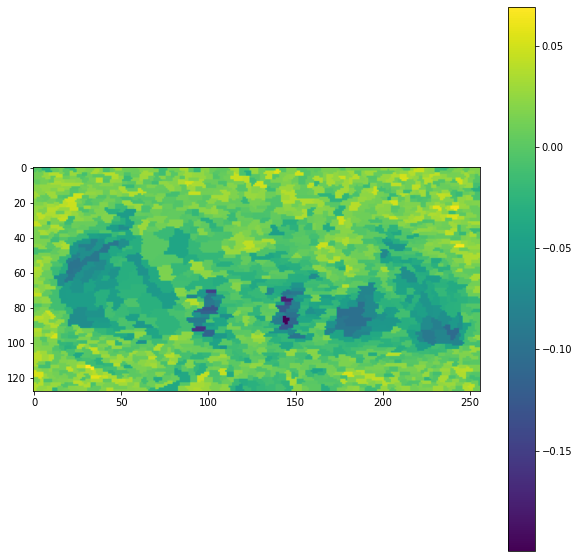

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(whole_corr_reformed[20,:,:].T)
plt.colorbar()

In [96]:
###################
### corr with Y ###
###################

# shifted_beh_z = np.roll(fictrac['Y'][:,0],8)

behavior = 'dRotLabY'
corrs_y = []
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    for x in range(256):
        for y in range(128):
            corrs_y.append(scipy.stats.pearsonr(neural[x,y,z,:], fictrac_trace.flatten())[0])

In [141]:
###################
### corr with Z left turn ###
###################

# shifted_beh_z = np.clip(np.roll(fictrac['Z'][:,0],8),None,0)*-1
behavior = 'dRotLabZ'
corrs_z_l = []
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1
    for x in range(256):
        for y in range(128):
            corrs_z_l.append(scipy.stats.pearsonr(neural[x,y,z,:], fictrac_trace_L.flatten())[0])

In [98]:
###############################
### corr with Z right turn ###
##############################

# shifted_beh_z = np.clip(np.roll(fictrac['Z'][:,0],8),None,0)*-1
behavior = 'dRotLabZ'
corrs_z_r = []
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_R = np.clip(fictrac_trace.flatten(),0,None)
    for x in range(256):
        for y in range(128):
            corrs_z_r.append(scipy.stats.pearsonr(neural[x,y,z,:], fictrac_trace_R.flatten())[0])

In [99]:
whole_corr_ZPOS = np.reshape(np.asarray(corrs_y),(49,256,128))

In [142]:
whole_corr = np.reshape(np.asarray(corrs_z_l),(49,256,128))

In [143]:
whole_corr.shape

(49, 256, 128)

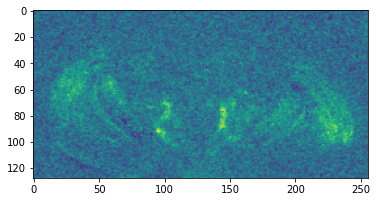

In [144]:
plt.imshow(whole_corr[20,:,:].T)

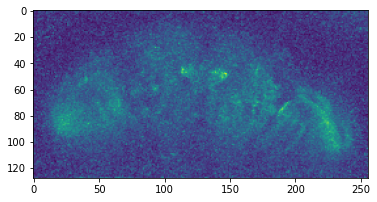

In [103]:
plt.imshow(np.max(whole_corr,axis=0).T)

In [145]:
maxi_projection = np.max(whole_corr, axis = 0)

In [146]:
whole_corr.shape

(49, 256, 128)

In [147]:
whole_corr_reformed.shape

(49, 256, 128)

In [148]:
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
STA_brain.shape

(49, 1, 256, 128)

In [37]:
#(49, 1, 256, 128) this is correct

In [149]:
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_231', fixed=fixed, anat_to_mean_type='myr')

In [150]:
fixed.shape

(314, 146, 91)

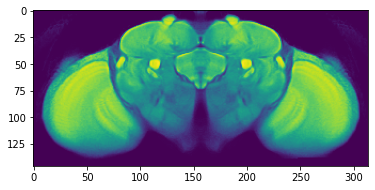

In [151]:
plt.imshow(fixed[:,:,40].T)

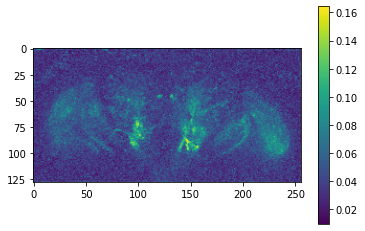

In [152]:
plt.imshow(maxi_projection.T)
plt.colorbar()

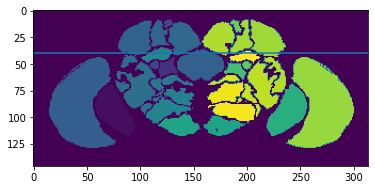

In [71]:
plt.imshow(atlas[:,:,53].T)
plt.axhline(40)

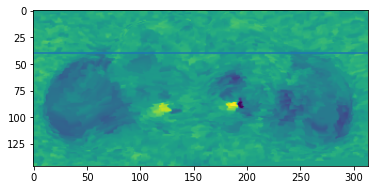

In [158]:
plt.imshow(data_to_plot[:,:,53].T)
plt.axhline(40)

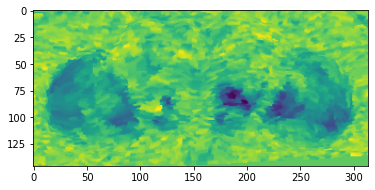

In [178]:
plt.imshow(data_to_plot[:,:,60].T)

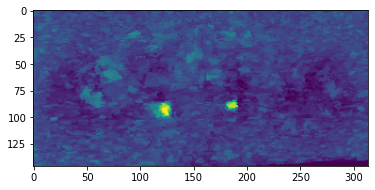

In [161]:
plt.imshow(np.max(data_to_plot,axis=2).T)

In [188]:
input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warps_ZPOS[0][:,:,::-1]
vmax = .3
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')

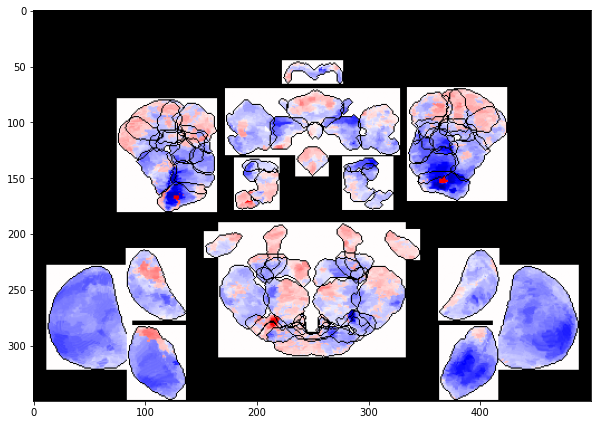

In [189]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

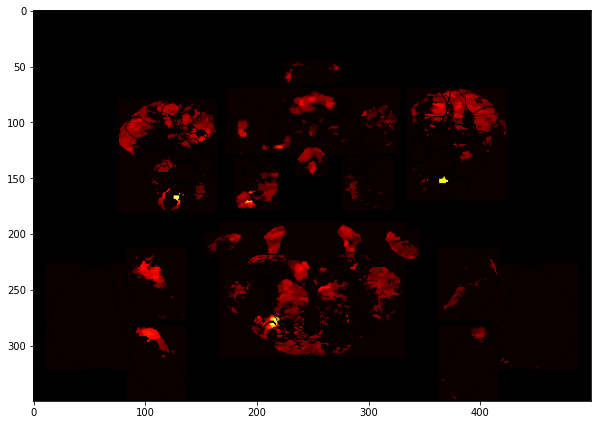

In [157]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])